<a href="https://colab.research.google.com/github/AdamBaker1507/AI-Facial-Recognition-Assignment/blob/main/Final_AI_Facial_Recog_Notebook_for_LBP%2BHOG_Features_and_SVM_Classifier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MAIN CODE**

# **INITIALIZATION**

I have decided to show all the imports and froms as one section to keep it clean knowing it might cause confusion later in the code. To rectify this, I have commented where everything will be used.

In [ ]:
import cv2
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage.exposure import histogram
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **EXTRACTION AND DEFINITION OF METHODS (HOG, LBP AND FACE DETECTION)**

In [ ]:
def extract_hog_features(images):
  hog_features = []
  for img in images:
    img = cv2.resize(img, (64, 64))
    hog_feat = hog(img, orientations=8, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), block_norm='L2-Hys')
    hog_features.append(hog_feat)
  return np.array(hog_features)

In [ ]:
face_cascade = cv2.CascadeClassifier("/content/drive/My Drive/AI Lab content/Lab 6 Content/haarcascade_frontalface_default.xml")

def load_and_detect_faces(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    faces = face_cascade.detectMultiScale(img, scaleFactor = 1.1, minNeighbors = 5, minSize=(30,30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w] #crops out non facial-features
                        images.append(face_region)
                        labels.append(label)
    return images, labels

def extract_lbp_features(images):
  lbp_features = []
  for img in images:
    # Resize image to 64x64
    img_resized = cv2.resize(img, (64, 64))
    # P for Number of circularly symmetric neighbour points to consider
    # R for Radius of circle
    # method='uniform' Uses uniform LBP which is robust to rotation
    lbp = local_binary_pattern(img_resized, P=8, R=1, method='uniform')

    # Compute histogram of LBP values and normalize it
    (hist, _) = histogram(lbp, nbins=int(lbp.max() + 1))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    lbp_features.append(hist)
  return np.array(lbp_features)

def extract_combined_features(images):
  # Extract HOG features
  hog_feats = extract_hog_features(images)
  # Extract LBP features
  lbp_feats = extract_lbp_features(images)

  # Ensure LBP features are 2D arrays before concatenation
  if len(lbp_feats.shape) == 1:
    # This case handles when lbp_feats is (num_samples,) where each element is a 1D array
    if len(lbp_feats) > 0 and isinstance(lbp_feats[0], np.ndarray):
        lbp_feats = np.vstack(lbp_feats)
    elif len(lbp_feats) > 0: # handles when lbp_feats is a 1D array of scalar values
        lbp_feats = lbp_feats.reshape(-1, 1)

  # Concatenate HOG and LBP features
  if hog_feats.size > 0 and lbp_feats.size > 0:
    combined_feats = np.hstack((hog_feats, lbp_feats))
  elif hog_feats.size > 0:
    combined_feats = hog_feats
  elif lbp_feats.size > 0:
    combined_feats = lbp_feats
  else:
    combined_feats = np.array([])

  return combined_feats

print("LBP and Combined feature extraction functions defined and moved.")

LBP and Combined feature extraction functions defined and moved.


# **DATASET DEFINITION AND COMBINATION (MERGED METHOD)**

In [ ]:
ck_train_folder_path = '/content/drive/My Drive/AI Lab content/Assignment Datasets/CK_dataset/train'
ck_test_folder_path = '/content/drive/My Drive/AI Lab content/Assignment Datasets/CK_dataset/test'



In [ ]:
# Paths for CK_dataset
ck_train_folder_path = '/content/drive/My Drive/AI Lab content/Assignment Datasets/CK_dataset/train'
ck_test_folder_path = '/content/drive/My Drive/AI Lab content/Assignment Datasets/CK_dataset/test'

# Paths for JAFFE-[70,30] dataset
jaffe_train_folder_path = '/content/drive/My Drive/AI Lab content/Assignment Datasets/JAFFE-[70,30]/train'
jaffe_test_folder_path = '/content/drive/My Drive/AI Lab content/Assignment Datasets/JAFFE-[70,30]/test'

print("Loading and Combining Training Data")
# Load CK training data
print(f"Loading data from CK train folder: {ck_train_folder_path}")
ck_train_images, ck_train_labels = load_and_detect_faces(ck_train_folder_path)

# Load JAFFE training data
print(f"Loading data from JAFFE train folder: {jaffe_train_folder_path}")
jaffe_train_images, jaffe_train_labels = load_and_detect_faces(jaffe_train_folder_path)

# Combine the training images and labels
x_train = ck_train_images + jaffe_train_images
y_train = ck_train_labels + jaffe_train_labels
print(f"Total combined training images: {len(x_train)}")
print(f"Total combined training labels: {len(y_train)}")

print("\n Loading and Combining Testing Data")
# Load CK testing data
print(f"Loading data from CK test folder: {ck_test_folder_path}")
ck_test_images, ck_test_labels = load_and_detect_faces(ck_test_folder_path)

# Load JAFFE testing data
print(f"Loading data from JAFFE test folder: {jaffe_test_folder_path}")
jaffe_test_images, jaffe_test_labels = load_and_detect_faces(jaffe_test_folder_path)

# Combine the testing images and labels
x_test = ck_test_images + jaffe_test_images
y_test = ck_test_labels + jaffe_test_labels
print(f"Total combined testing images: {len(x_test)}")
print(f"Total combined testing labels: {len(y_test)}")

# Extract combined HOG and LBP features for the overall combined dataset
print("\nExtracting Combined HOG and LBP Features for Combined Training Data")
x_train_combined_features = extract_combined_features(x_train)
print(f"Shape of combined training features: {x_train_combined_features.shape}")

print("\nExtracting Combined HOG and LBP Features for Combined Testing Data")
x_test_combined_features = extract_combined_features(x_test)
print(f"Shape of combined testing features: {x_test_combined_features.shape}")

print("\n Encoding Labels")
# Combine all unique labels from train and test sets to ensure consistent encoding
all_unique_labels = list(set(y_train + y_test))
label_encoder = LabelEncoder()
label_encoder.fit(all_unique_labels)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print("Labels encoded successfully.")
print(f"Classes learned by encoder: {label_encoder.classes_}")

Loading and Combining Training Data
Loading data from CK train folder: /content/drive/My Drive/AI Lab content/Assignment Datasets/CK_dataset/train
Loading data from JAFFE train folder: /content/drive/My Drive/AI Lab content/Assignment Datasets/JAFFE-[70,30]/train
Total combined training images: 468
Total combined training labels: 468

 Loading and Combining Testing Data
Loading data from CK test folder: /content/drive/My Drive/AI Lab content/Assignment Datasets/CK_dataset/test
Loading data from JAFFE test folder: /content/drive/My Drive/AI Lab content/Assignment Datasets/JAFFE-[70,30]/test
Total combined testing images: 198
Total combined testing labels: 198

Extracting Combined HOG and LBP Features for Combined Training Data
Shape of combined training features: (468, 1578)

Extracting Combined HOG and LBP Features for Combined Testing Data
Shape of combined testing features: (198, 1578)

 Encoding Labels
Labels encoded successfully.
Classes learned by encoder: ['anger' 'fear' 'happy' 

# **Separate Extraction of CK Dataset**

In [ ]:
print("Processing CK Dataset")

# Load CK training data
print(f"Loading data from CK train folder: {ck_train_folder_path}")
ck_x_train_images, ck_y_train_labels = load_and_detect_faces(ck_train_folder_path)
print(f"Total CK training images: {len(ck_x_train_images)}")

# Load CK testing data
print(f"Loading data from CK test folder: {ck_test_folder_path}")
ck_x_test_images, ck_y_test_labels = load_and_detect_faces(ck_test_folder_path)
print(f"Total CK testing images: {len(ck_x_test_images)}")

print("\nExtracting Combined HOG and LBP Features for CK Training Data")
ck_x_train_processed_for_features = []
for img in ck_x_train_images:
    if img.ndim == 3 and img.shape[2] == 1:
        ck_x_train_processed_for_features.append(img.squeeze())
    elif img.ndim == 2:
        ck_x_train_processed_for_features.append(img)
    else:
        if img.ndim == 3 and img.shape[2] == 3:
            ck_x_train_processed_for_features.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        else:
            ck_x_train_processed_for_features.append(img)

ck_x_train_combined_features = extract_combined_features(ck_x_train_processed_for_features)
print(f"Shape of CK combined training features: {ck_x_train_combined_features.shape}")

print("\nExtracting Combined HOG and LBP Features for CK Testing Data")
ck_x_test_processed_for_features = []
for img in ck_x_test_images:
    if img.ndim == 3 and img.shape[2] == 1:
        ck_x_test_processed_for_features.append(img.squeeze())
    elif img.ndim == 2:
        ck_x_test_processed_for_features.append(img)
    else:
        if img.ndim == 3 and img.shape[2] == 3:
            ck_x_test_processed_for_features.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        else:
            ck_x_test_processed_for_features.append(img)

ck_x_test_combined_features = extract_combined_features(ck_x_test_processed_for_features)
print(f"Shape of CK combined testing features: {ck_x_test_combined_features.shape}")

print("\nEncoding CK Labels")
# Use the same label_encoder fitted on all unique labels for consistency
ck_y_train_encoded = label_encoder.transform(ck_y_train_labels)
ck_y_test_encoded = label_encoder.transform(ck_y_test_labels)
print("CK Labels encoded successfully.")

Processing CK Dataset
Loading data from CK train folder: /content/drive/My Drive/AI Lab content/Assignment Datasets/CK_dataset/train
Total CK training images: 340
Loading data from CK test folder: /content/drive/My Drive/AI Lab content/Assignment Datasets/CK_dataset/test
Total CK testing images: 143

Extracting Combined HOG and LBP Features for CK Training Data
Shape of CK combined training features: (340, 1578)

Extracting Combined HOG and LBP Features for CK Testing Data
Shape of CK combined testing features: (143, 1578)

Encoding CK Labels
CK Labels encoded successfully.


### **Separate Extraction of JAFFE Dataset**

In [ ]:
print("Processing JAFFE Dataset")

# Load JAFFE training data
print(f"Loading data from JAFFE train folder: {jaffe_train_folder_path}")
jaffe_x_train_images, jaffe_y_train_labels = load_and_detect_faces(jaffe_train_folder_path)
print(f"Total JAFFE training images: {len(jaffe_x_train_images)}")

# Load JAFFE testing data
print(f"Loading data from JAFFE test folder: {jaffe_test_folder_path}")
jaffe_x_test_images, jaffe_y_test_labels = load_and_detect_faces(jaffe_test_folder_path)
print(f"Total JAFFE testing images: {len(jaffe_x_test_images)}")

print("\nExtracting Combined HOG and LBP Features for JAFFE Training Data")
jaffe_x_train_processed_for_features = []
for img in jaffe_x_train_images:
    if img.ndim == 3 and img.shape[2] == 1:
        jaffe_x_train_processed_for_features.append(img.squeeze())
    elif img.ndim == 2:
        jaffe_x_train_processed_for_features.append(img)
    else:
        if img.ndim == 3 and img.shape[2] == 3:
            jaffe_x_train_processed_for_features.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        else:
            jaffe_x_train_processed_for_features.append(img)

jaffe_x_train_combined_features = extract_combined_features(jaffe_x_train_processed_for_features)
print(f"Shape of JAFFE combined training features: {jaffe_x_train_combined_features.shape}")

print("\nExtracting Combined HOG and LBP Features for JAFFE Testing Data")
jaffe_x_test_processed_for_features = []
for img in jaffe_x_test_images:
    if img.ndim == 3 and img.shape[2] == 1:
        jaffe_x_test_processed_for_features.append(img.squeeze())
    elif img.ndim == 2:
        jaffe_x_test_processed_for_features.append(img)
    else:
        if img.ndim == 3 and img.shape[2] == 3:
            jaffe_x_test_processed_for_features.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        else:
            jaffe_x_test_processed_for_features.append(img)

jaffe_x_test_combined_features = extract_combined_features(jaffe_x_test_processed_for_features)
print(f"Shape of JAFFE combined testing features: {jaffe_x_test_combined_features.shape}")

print("\nEncoding JAFFE Labels")
# Use the same label_encoder fitted on all unique labels for consistency
jaffe_y_train_encoded = label_encoder.transform(jaffe_y_train_labels)
jaffe_y_test_encoded = label_encoder.transform(jaffe_y_test_labels)
print("JAFFE Labels encoded successfully.")

Processing JAFFE Dataset
Loading data from JAFFE train folder: /content/drive/My Drive/AI Lab content/Assignment Datasets/JAFFE-[70,30]/train
Total JAFFE training images: 128
Loading data from JAFFE test folder: /content/drive/My Drive/AI Lab content/Assignment Datasets/JAFFE-[70,30]/test
Total JAFFE testing images: 55

Extracting Combined HOG and LBP Features for JAFFE Training Data
Shape of JAFFE combined training features: (128, 1578)

Extracting Combined HOG and LBP Features for JAFFE Testing Data
Shape of JAFFE combined testing features: (55, 1578)

Encoding JAFFE Labels
JAFFE Labels encoded successfully.


# **SVM CLASSIFIER**

# **SVM FOR CK DATASET**

Training and Evaluating SVM Classifier for CK Dataset
Finding optimal hyperparameters for SVM Classifier on CK Dataset
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Optimal SVM parameters found for CK Dataset: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Classifier for CK Dataset trained and predictions made.

Accuracy Score (SVM Classifier on CK Dataset): 0.6364


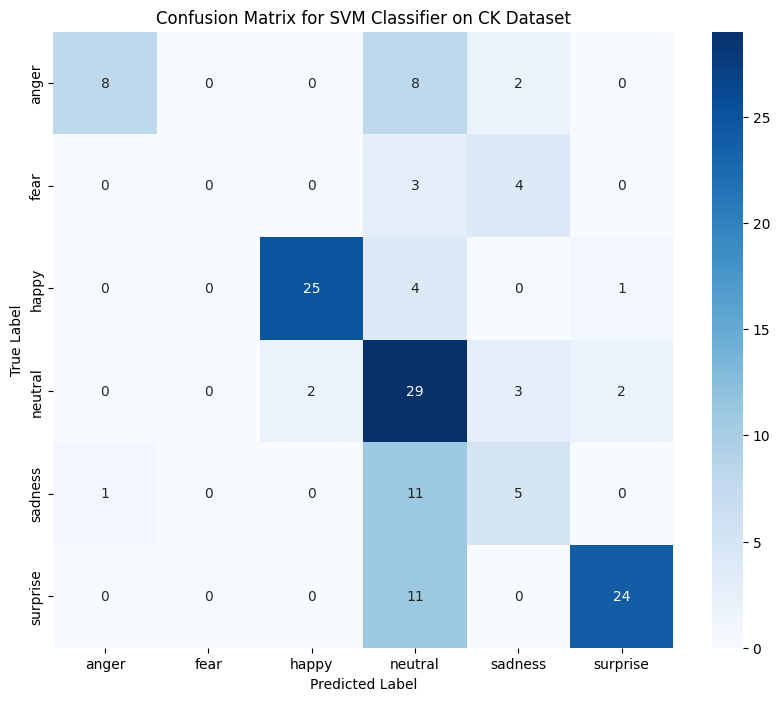


Classification Report (SVM Classifier on CK Dataset):
              precision    recall  f1-score   support

       anger       0.89      0.44      0.59        18
        fear       0.00      0.00      0.00         7
       happy       0.93      0.83      0.88        30
     neutral       0.44      0.81      0.57        36
     sadness       0.36      0.29      0.32        17
    surprise       0.89      0.69      0.77        35

    accuracy                           0.64       143
   macro avg       0.58      0.51      0.52       143
weighted avg       0.68      0.64      0.63       143



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("Training and Evaluating SVM Classifier for CK Dataset")

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Instantiate SVC classifier
svm_classifier_ck = SVC(random_state=42)

# Instantiate GridSearchCV
grid_search_svm_ck = GridSearchCV(svm_classifier_ck, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the CK training features and encoded labels
print("Finding optimal hyperparameters for SVM Classifier on CK Dataset")
grid_search_svm_ck.fit(ck_x_train_combined_features, ck_y_train_encoded)

# Print the best parameters found
best_svm_params_ck = grid_search_svm_ck.best_params_
print(f"Optimal SVM parameters found for CK Dataset: {best_svm_params_ck}")

# Get the best estimator and make predictions on the CK test set
best_svm_model_ck = grid_search_svm_ck.best_estimator_
y_pred_svm_ck = best_svm_model_ck.predict(ck_x_test_combined_features)

print("SVM Classifier for CK Dataset trained and predictions made.")

# Calculate and print accuracy score
accuracy_svm_ck = accuracy_score(ck_y_test_encoded, y_pred_svm_ck)
print(f"\nAccuracy Score (SVM Classifier on CK Dataset): {accuracy_svm_ck:.4f}")

# Generate and plot confusion matrix
cm_svm_ck = confusion_matrix(ck_y_test_encoded, y_pred_svm_ck)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm_ck, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for SVM Classifier on CK Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("\nClassification Report (SVM Classifier on CK Dataset):")
print(classification_report(ck_y_test_encoded, y_pred_svm_ck, target_names=label_encoder.classes_))

# **SVM FOR JAFFE DATASET**

Training and Evaluating SVM Classifier for JAFFE Dataset
Finding optimal hyperparameters for SVM Classifier on JAFFE Dataset
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Optimal SVM parameters found for JAFFE Dataset: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Classifier for JAFFE Dataset trained and predictions made.

Accuracy Score (SVM Classifier on JAFFE Dataset): 0.8182


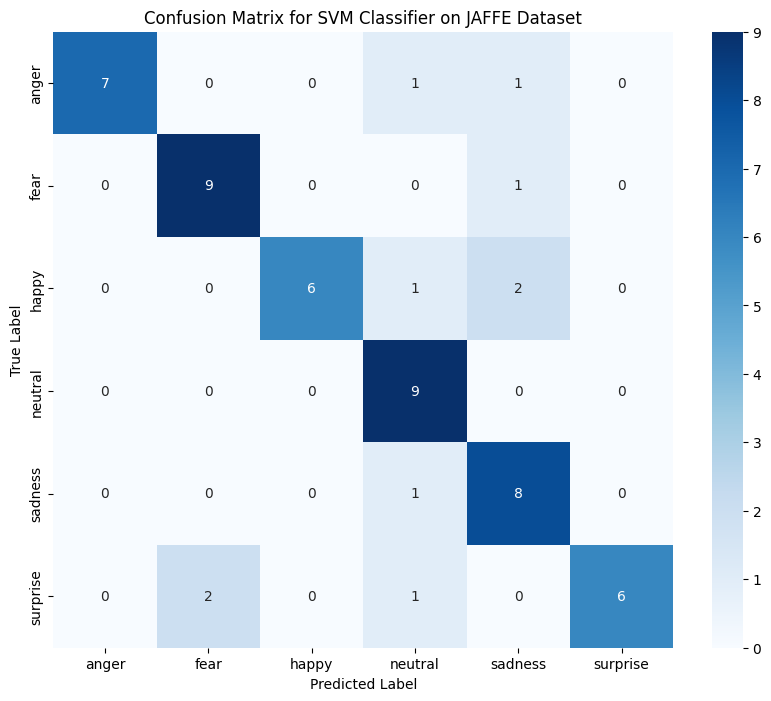


Classification Report (SVM Classifier on JAFFE Dataset):
              precision    recall  f1-score   support

       anger       1.00      0.78      0.88         9
        fear       0.82      0.90      0.86        10
       happy       1.00      0.67      0.80         9
     neutral       0.69      1.00      0.82         9
     sadness       0.67      0.89      0.76         9
    surprise       1.00      0.67      0.80         9

    accuracy                           0.82        55
   macro avg       0.86      0.82      0.82        55
weighted avg       0.86      0.82      0.82        55



In [ ]:
print("Training and Evaluating SVM Classifier for JAFFE Dataset")

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Instantiate SVC classifier
svm_classifier_jaffe = SVC(random_state=42)

# Instantiate GridSearchCV
grid_search_svm_jaffe = GridSearchCV(svm_classifier_jaffe, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the JAFFE training features and encoded labels
print("Finding optimal hyperparameters for SVM Classifier on JAFFE Dataset")
grid_search_svm_jaffe.fit(jaffe_x_train_combined_features, jaffe_y_train_encoded)

# Print the best parameters found
best_svm_params_jaffe = grid_search_svm_jaffe.best_params_
print(f"Optimal SVM parameters found for JAFFE Dataset: {best_svm_params_jaffe}")

# Get the best estimator and make predictions on the JAFFE test set
best_svm_model_jaffe = grid_search_svm_jaffe.best_estimator_
y_pred_svm_jaffe = best_svm_model_jaffe.predict(jaffe_x_test_combined_features)

print("SVM Classifier for JAFFE Dataset trained and predictions made.")

# Calculate and print accuracy score
accuracy_svm_jaffe = accuracy_score(jaffe_y_test_encoded, y_pred_svm_jaffe)
print(f"\nAccuracy Score (SVM Classifier on JAFFE Dataset): {accuracy_svm_jaffe:.4f}")

# Generate and plot confusion matrix
cm_svm_jaffe = confusion_matrix(jaffe_y_test_encoded, y_pred_svm_jaffe)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm_jaffe, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for SVM Classifier on JAFFE Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("\nClassification Report (SVM Classifier on JAFFE Dataset):")
print(classification_report(jaffe_y_test_encoded, y_pred_svm_jaffe, target_names=label_encoder.classes_))

# **SVM FOR COMBINED DATASETS**

Training and Evaluating Support Vector Machine (SVM) Classifier
Finding optimal hyperparameters for SVM Classifier 
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Optimal SVM parameters found: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Classifier trained and predictions made.

Accuracy Score (SVM Classifier): 0.6818


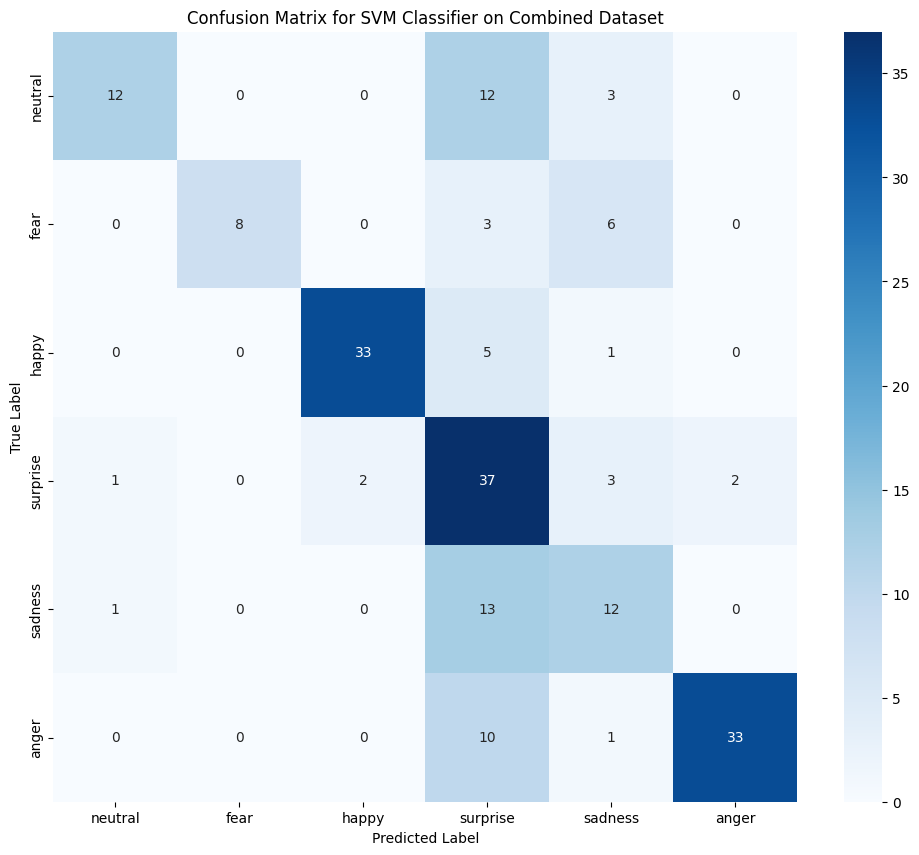


Classification Report (SVM Classifier):
              precision    recall  f1-score   support

     neutral       0.86      0.44      0.59        27
        fear       1.00      0.47      0.64        17
       happy       0.94      0.85      0.89        39
    surprise       0.46      0.82      0.59        45
     sadness       0.46      0.46      0.46        26
       anger       0.94      0.75      0.84        44

    accuracy                           0.68       198
   macro avg       0.78      0.63      0.67       198
weighted avg       0.76      0.68      0.69       198



In [ ]:
print("Training and Evaluating Support Vector Machine (SVM) Classifier")

# Define the parameter grid for SVM (kernel types and C values)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'], # linear and RBF kernels
    'gamma': ['scale', 'auto'] # Kernel coefficient for rbf
}

# Instantiate SVC classifier
svm_classifier = SVC(random_state=42)

# Instantiate GridSearchCV
grid_search_svm = GridSearchCV(svm_classifier, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the combined training features and extended encoded labels
print("Finding optimal hyperparameters for SVM Classifier ")
grid_search_svm.fit(x_train_combined_features, y_train_encoded)

# Print the best parameters found
best_svm_params = grid_search_svm.best_params_
print(f"Optimal SVM parameters found: {best_svm_params}")

# Get the best estimator and make predictions on the test set
best_svm_model = grid_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(x_test_combined_features)

print("SVM Classifier trained and predictions made.")

# Calculate and print accuracy score
accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)
print(f"\nAccuracy Score (SVM Classifier): {accuracy_svm:.4f}")

# Generate and plot confusion matrix
cm_svm = confusion_matrix(y_test_encoded, y_pred_svm)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_unique_labels, yticklabels=all_unique_labels)
plt.title('Confusion Matrix for SVM Classifier on Combined Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("\nClassification Report (SVM Classifier):")
print(classification_report(y_test_encoded, y_pred_svm, target_names=all_unique_labels))

# **PREDICTIONS**

Found successful predictions for 3 different emotions.
Displaying 3 randomly selected successful predictions, aiming for different emotions.


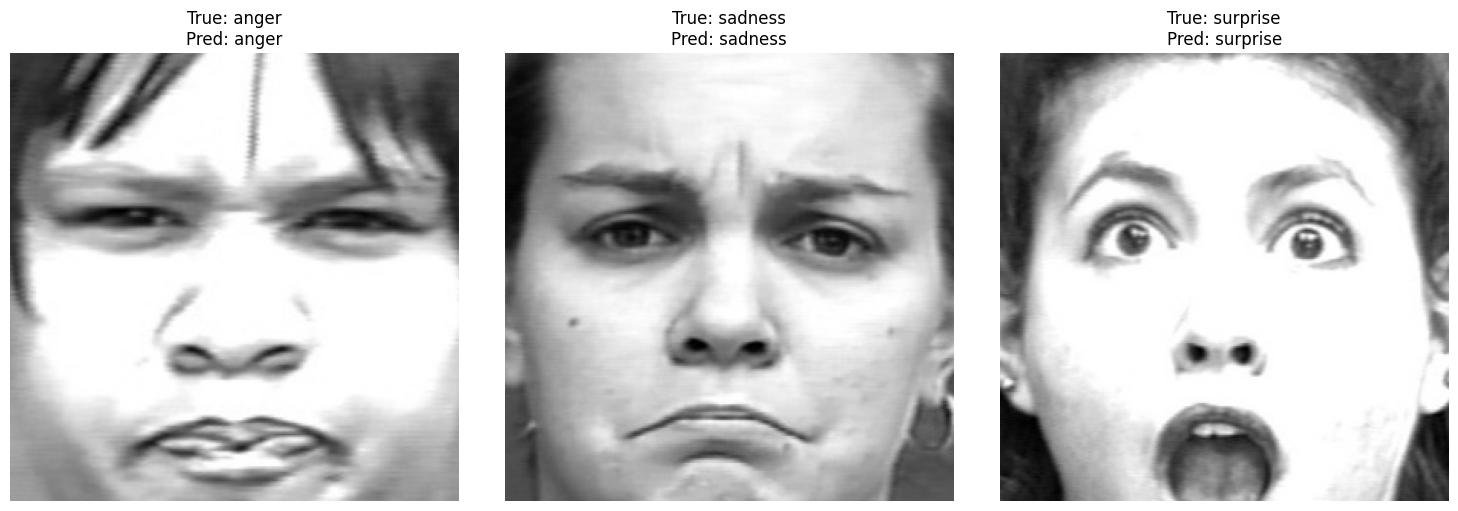

In [ ]:
import matplotlib.pyplot as plt
import random

# Desired number of DIFFERENT emotions to display
num_different_emotions_to_show = 3

# Dictionary to store one successful prediction per emotion
successful_predictions_by_emotion = {}

# Iterate through the combined test set to find successful predictions for each emotion
for i in range(len(x_test)):
    true_label_encoded_combined = y_test_encoded[i]
    predicted_label_encoded_combined = y_pred_svm[i]

    if true_label_encoded_combined == predicted_label_encoded_combined:
        true_label_combined = label_encoder.inverse_transform([true_label_encoded_combined])[0]

        # If it hasn't stored a prediction for this emotion yet, store it
        if true_label_combined not in successful_predictions_by_emotion:
            successful_predictions_by_emotion[true_label_combined] = {
                'image': x_test[i],
                'true_label': true_label_combined,
                'predicted_label': label_encoder.inverse_transform([predicted_label_encoded_combined])[0]
            }

        # Stop if not enough different emotions
        if len(successful_predictions_by_emotion) >= num_different_emotions_to_show:
            break

print(f"Found successful predictions for {len(successful_predictions_by_emotion)} different emotions.")

# Convert the dictionary values to a list for display
successful_predictions_to_display = list(successful_predictions_by_emotion.values())

# If still don't have enough (if there aren't 3 different emotions successfully predicted),
# can try to fill with any remaining successful ones, or just show what is currently available
# For this request, will ensure it shows at least 3 if available.
if len(successful_predictions_to_display) < num_different_emotions_to_show:
    # If not enough distinct emotions, get more random successful predictions to fill up to num_different_emotions_to_show
    all_successful_predictions_combined = []
    for i in range(len(x_test)):
        true_label_encoded_combined = y_test_encoded[i]
        predicted_label_encoded_combined = y_pred_svm[i]
        if true_label_encoded_combined == predicted_label_encoded_combined:
            all_successful_predictions_combined.append({
                'image': x_test[i],
                'true_label': label_encoder.inverse_transform([true_label_encoded_combined])[0],
                'predicted_label': label_encoder.inverse_transform([predicted_label_encoded_combined])[0]
            })

    # Add more random ones if still needed and available
    num_needed = num_different_emotions_to_show - len(successful_predictions_to_display)
    remaining_successful = [p for p in all_successful_predictions_combined if p not in successful_predictions_to_display]
    if len(remaining_successful) > num_needed:
        successful_predictions_to_display.extend(random.sample(remaining_successful, num_needed))
    else:
        successful_predictions_to_display.extend(remaining_successful)

print(f"Displaying {len(successful_predictions_to_display)} randomly selected successful predictions, aiming for different emotions.")

# Display the selected successful predictions
if successful_predictions_to_display:
    fig, axes = plt.subplots(1, len(successful_predictions_to_display), figsize=(15, 5))
    if len(successful_predictions_to_display) == 1:
        axes = [axes] # Make it iterable if only one subplot
    for j, pred_data in enumerate(successful_predictions_to_display):
        ax = axes[j]
        ax.imshow(pred_data['image'], cmap='gray')
        ax.set_title(f"True: {pred_data['true_label']}\nPred: {pred_data['predicted_label']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No successful predictions found to display for the combined dataset.")


In [ ]:
print("Training Accuracy")

# Training Accuracy for CK Dataset
training_accuracy_svm_ck = best_svm_model_ck.score(ck_x_train_combined_features, ck_y_train_encoded)
print(f"Training Accuracy (SVM Classifier on CK Dataset): {training_accuracy_svm_ck:.4f}")

# Training Accuracy for JAFFE Dataset
training_accuracy_svm_jaffe = best_svm_model_jaffe.score(jaffe_x_train_combined_features, jaffe_y_train_encoded)
print(f"Training Accuracy (SVM Classifier on JAFFE Dataset): {training_accuracy_svm_jaffe:.4f}")

# Training Accuracy for Combined Dataset
training_accuracy_svm_combined = best_svm_model.score(x_train_combined_features, y_train_encoded)
print(f"Training Accuracy (SVM Classifier on Combined Dataset): {training_accuracy_svm_combined:.4f}")


Training Accuracy
Training Accuracy (SVM Classifier on CK Dataset): 0.8382
Training Accuracy (SVM Classifier on JAFFE Dataset): 1.0000
Training Accuracy (SVM Classifier on Combined Dataset): 0.8761
